1. импорт данных

**NY-House-Dataset.**
***Гучиов Джамбек Аюбович***
***БИВТ-22-СП-1***

In [3]:
import pandas as pd
file_path = 'NY-House-Dataset.csv'
df = pd.read_csv(file_path)
df.head()

,BROKERTITLE,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,ADDRESS,STATE,MAIN_ADDRESS,ADMINISTRATIVE_AREA_LEVEL_2,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,FORMATTED_ADDRESS,LATITUDE,LONGITUDE
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.000000,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.000000,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.000000,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109
3,Brokered by COMPASS,Condo for sale,69000,3,1.000000,445.0,2 E 55th St Unit 908W33,"Manhattan, NY 10022","2 E 55th St Unit 908W33Manhattan, NY 10022",United States,New York,New York County,New York,East 55th Street,"2 E 55th St, New York, NY 10022, USA",40.761398,-73.974613
4,Brokered by Sotheby's International Realty - E...,Townhouse for sale,55000000,7,2.373861,14175.0,5 E 64th St,"New York, NY 10065","5 E 64th StNew York, NY 10065",United States,New York,New York County,New York,East 64th Street,"5 E 64th St, New York, NY 10065, USA",40.767224,-73.969856


2. описание задачи

Предпологаю, что EDA для датасета заключается в исследовании факторов, влияющих на цену недвижимости в Нью-Йорке. Целью может быть создание модели для прогнозирования стоимости жилья на основе предоставленных фичей. Это задача регрессии.

**Описание переменных**

BROKERTITLE: Название брокерской компании, предлагающей недвижимость.

TYPE: Тип недвижимости (например, "Condo for sale", "House for sale").

PRICE: Цена недвижимости (целевая переменная).

BEDS: Количество спален.

BATH: Количество ванных комнат.

PROPERTYSQFT: Площадь недвижимости в квадратных футах.

ADDRESS: Полный адрес недвижимости.

STATE: Штат, в котором расположена недвижимость.

MAIN_ADDRESS: Основной адрес недвижимости.

ADMINISTRATIVE_AREA_LEVEL_2: Административный район.

LOCALITY: Город или населенный пункт.

SUBLOCALITY: Район или округ.

STREET_NAME: Название улицы.

LONG_NAME: Полное название улицы.

FORMATTED_ADDRESS: Форматированный адрес.

LATITUDE: Широта.

LONGITUDE: Долгота.

**Целевая переменная — PRICE, являющаяся непрерывной.**

3. распределение целевой переменной

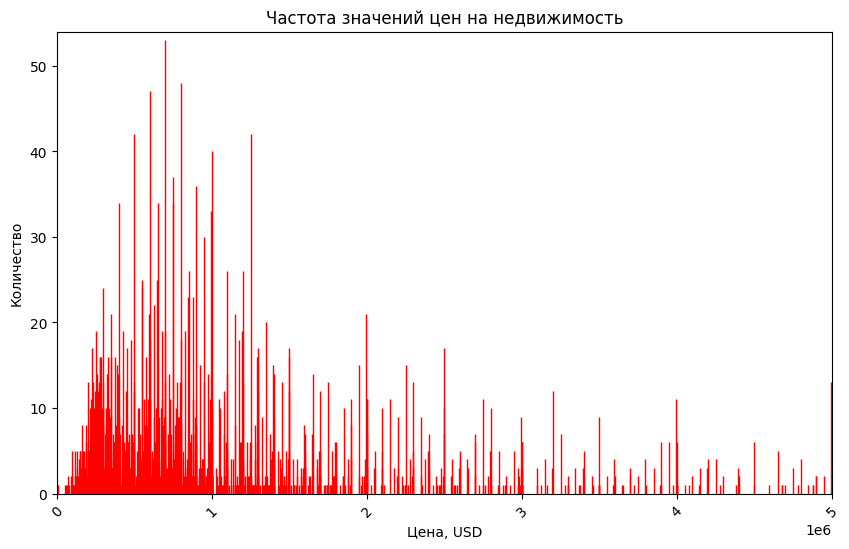

Количество уникальных значений цены: 1274


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
price_counts = df['PRICE'].value_counts().sort_index()


plt.figure(figsize=(10, 6))
plt.bar(price_counts.index, price_counts.values, edgecolor='red')

plt.title("Частота значений цен на недвижимость")
plt.xlabel("Цена, USD")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.xlim(0, 5000000)
plt.ylim(0, max(price_counts.values) + 1)
plt.show()


unique_prices = df['PRICE'].nunique()
print(f"Количество уникальных значений цены: {unique_prices}")

**График можно аппроксимировать как распределение Фишера**

4. основные статистики по переменным в датасете

In [ ]:
df.describe() #Выведите основные статистики по переменным в датасете (для этого есть готовый метод в pandas, он считает count, min, max, mean, 25%, 50% и пр.). Это делается одним методом (вы его знаете).

,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
count,4.801000e+03,4801.000000,4801.000000,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862,40.714227,-73.941601
std,3.135525e+07,2.602315,1.946962,2377.140894,0.087676,0.101082
min,2.494000e+03,1.000000,0.000000,230.000000,40.499546,-74.253033
25%,4.990000e+05,2.000000,1.000000,1200.000000,40.639375,-73.987143
50%,8.250000e+05,3.000000,2.000000,2184.207862,40.726749,-73.949189
75%,1.495000e+06,4.000000,3.000000,2184.207862,40.771923,-73.870638
max,2.147484e+09,50.000000,50.000000,65535.000000,40.912729,-73.702450


5. основная информация по датасету

In [ ]:
df.info() #Выведите основную информацию по датасету (сколько всего колонок, каких они типов, сколько в них non-null элементов). Это делается одним методом (вы его знаете).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

6. количество пропусков

In [ ]:
df.isnull().sum() #Посчитайте количество пропусков элементов во всех колонках

,0
BROKERTITLE,0
TYPE,0
PRICE,0
BEDS,0
BATH,0
PROPERTYSQFT,0
ADDRESS,0
STATE,0
MAIN_ADDRESS,0
ADMINISTRATIVE_AREA_LEVEL_2,0


Пропусков нет, ура, все в порядке!

In [16]:
df = df[df['PRICE'] <= 3000000]

In [20]:
df['LOG_PRICE'] = np.log(df['PRICE'])

7. гистограммы 5 любых признаков

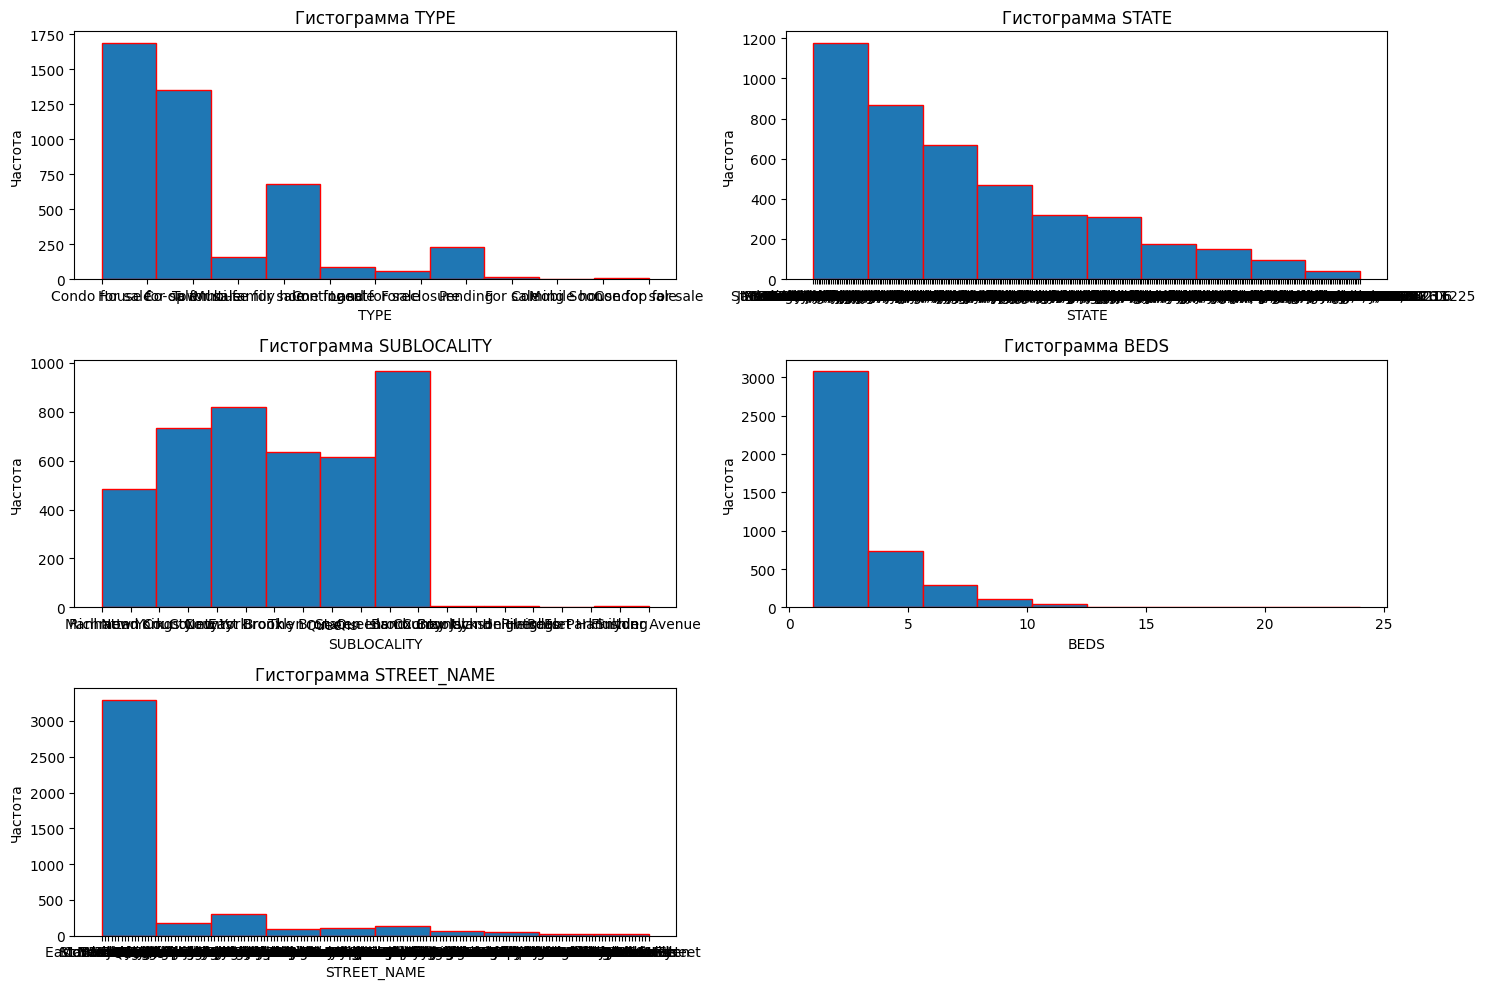

In [17]:
features = ['TYPE', 'STATE', 'SUBLOCALITY', 'BEDS', 'STREET_NAME']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    plt.hist(df[feature], bins=10, edgecolor='red')
    plt.title(f'Гистограмма {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Гистограмма по штатам, названию улиц, кол-во кроватей, очень *приближенно* по типу распределены как производная от функции $ y=ln(x)$ то есть $y=1/x, x∈(0, +∞)$


.
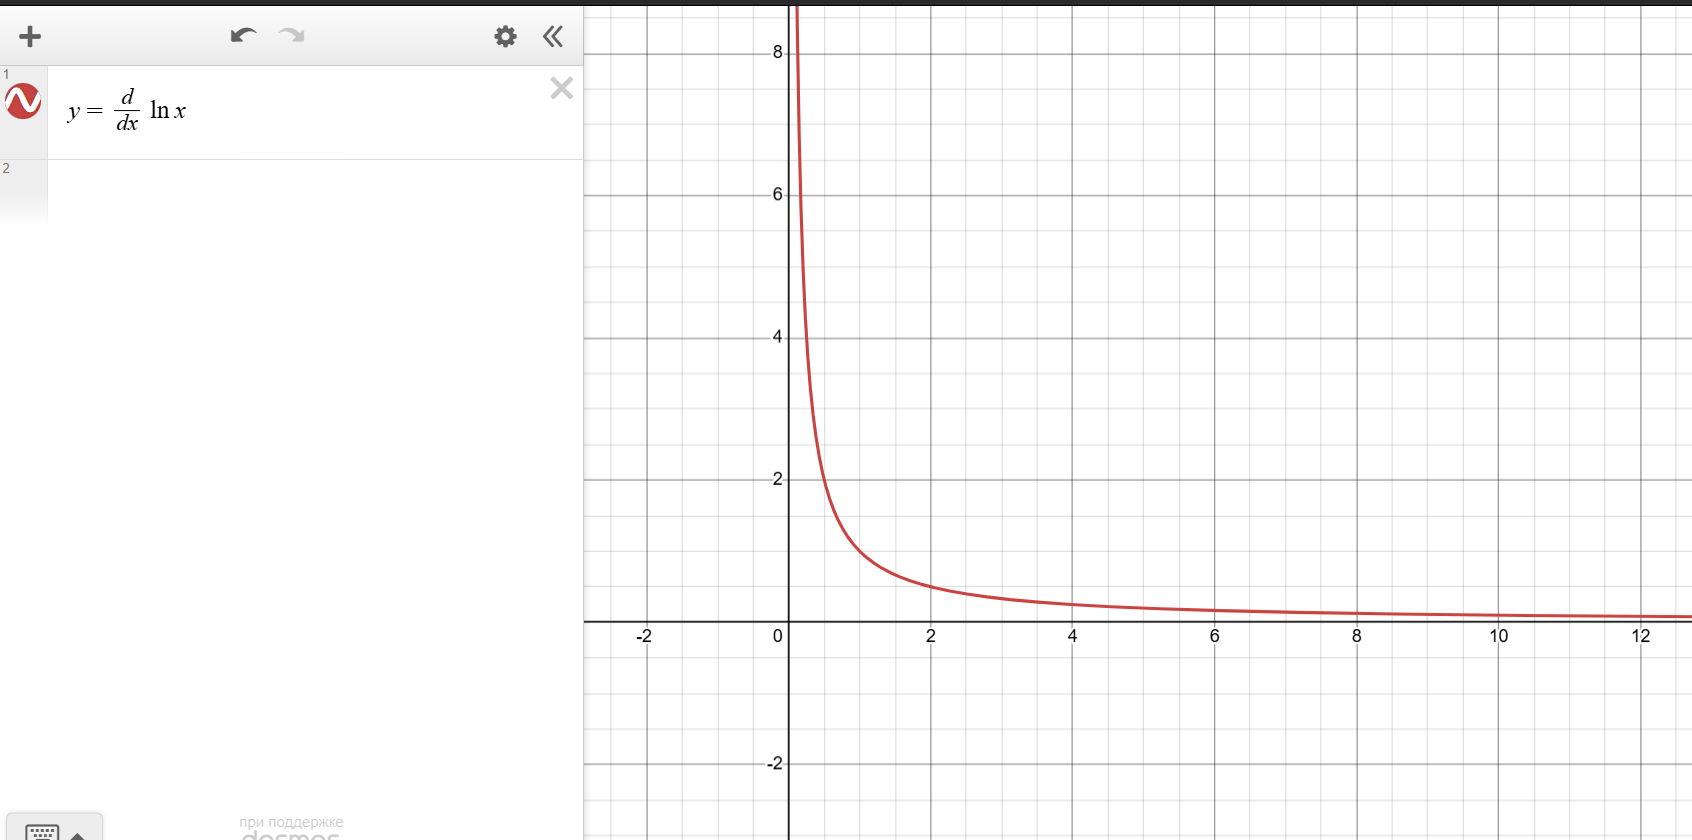

8. графики зависимости 5 любых переменных от целевой переменной

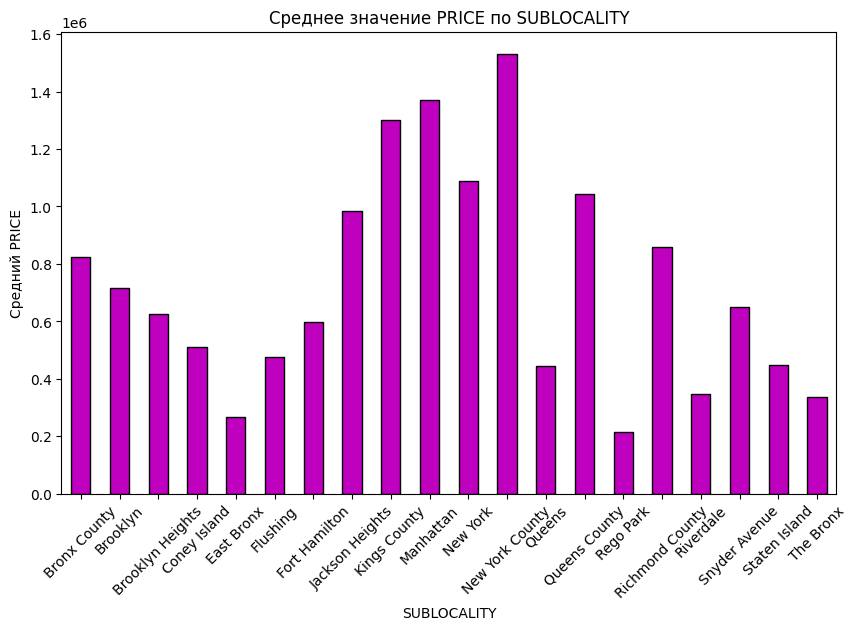

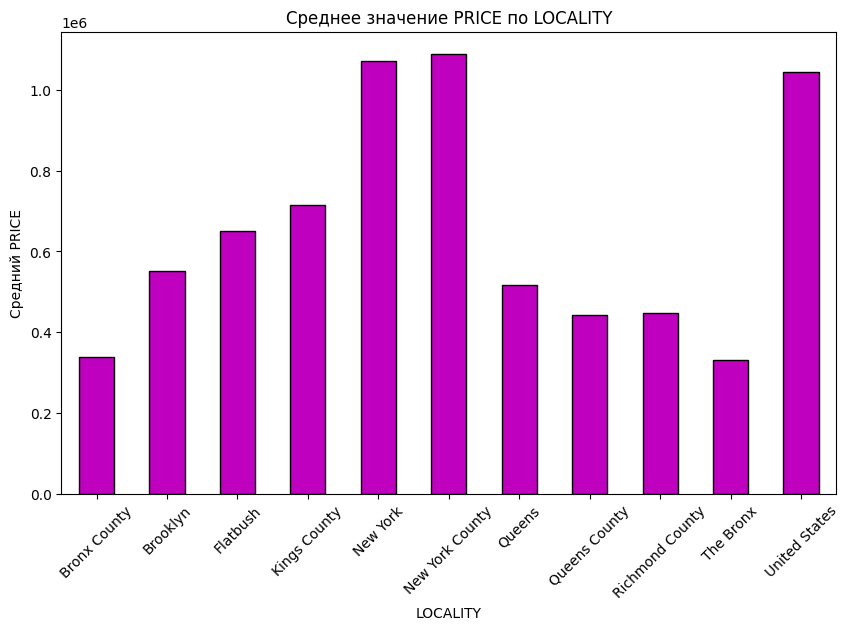

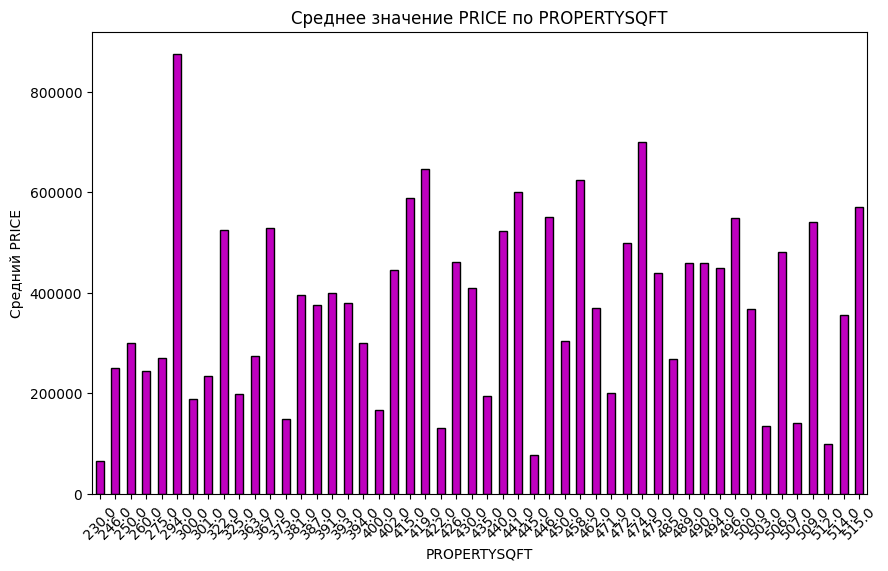

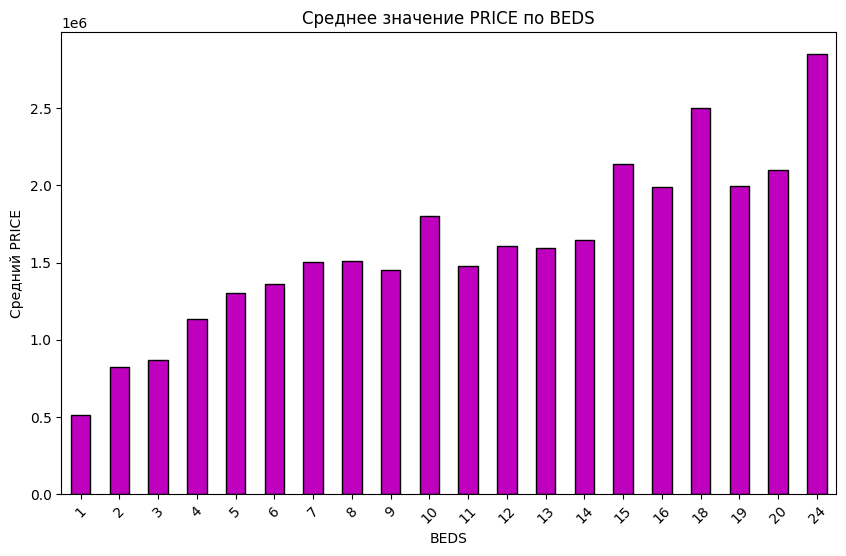

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
state_avg_price = df.groupby('SUBLOCALITY')['PRICE'].mean().head(100)
state_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение PRICE по SUBLOCALITY')
plt.xlabel('SUBLOCALITY')
plt.ylabel('Средний PRICE')
#plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
locality_avg_price = df.groupby('LOCALITY')['PRICE'].mean()
locality_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение PRICE по LOCALITY')
plt.xlabel('LOCALITY')
plt.ylabel('Средний PRICE')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
locality_avg_price = df.groupby('PROPERTYSQFT')['PRICE'].mean().head(50)
locality_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение PRICE по PROPERTYSQFT')
plt.xlabel('PROPERTYSQFT')
plt.ylabel('Средний PRICE')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(10, 6))
locality_avg_price = df.groupby('BEDS')['PRICE'].mean().head(100)
locality_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение PRICE по BEDS')
plt.xlabel('BEDS')
plt.ylabel('Средний PRICE')
plt.xticks(rotation=45)
plt.show()

plt.show()


Абсолютно очевидна корреляция дороговизны жилья с регионом расположения - дороже всего жить в Нью-Йорке, особенно в Бруклине и Кони Айленде. Это подтверждают две переменные - LOCALITY и SUBLOCALITY. Невозможно вывести очевидную корреляцию между ценой и площадью жилья и числом кроватей. В последнем случае наблюдается выброс на 7 кроватях, далее зависимость медленно кусочно-линейно возрастает.

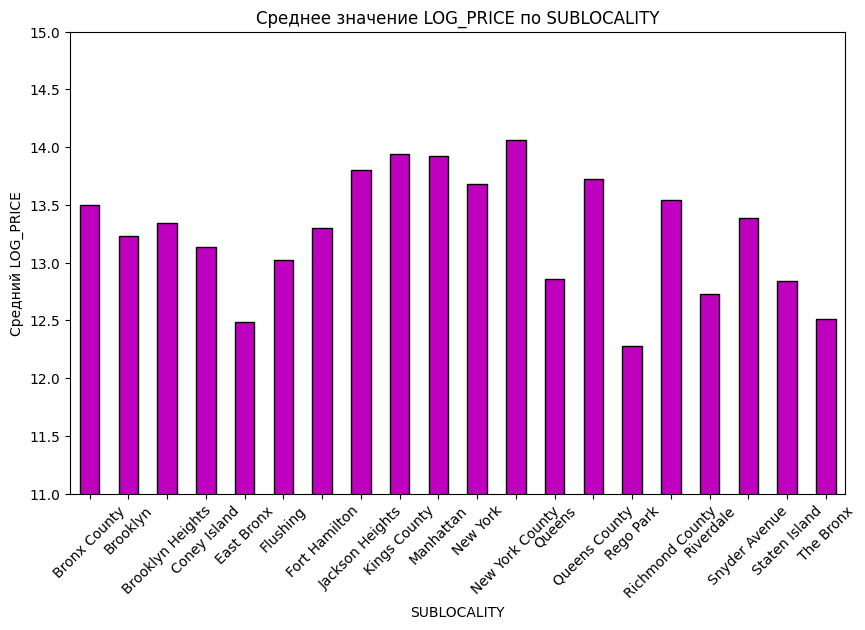

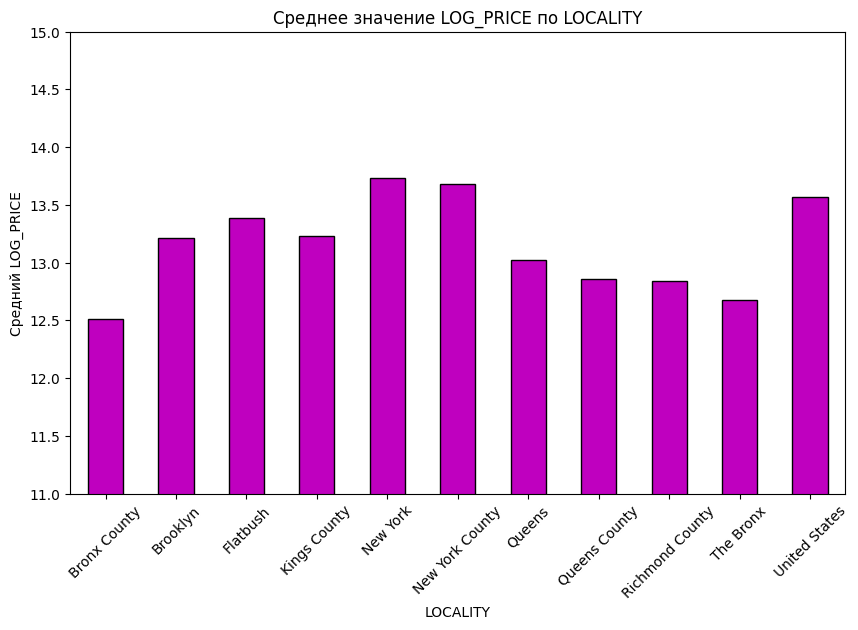

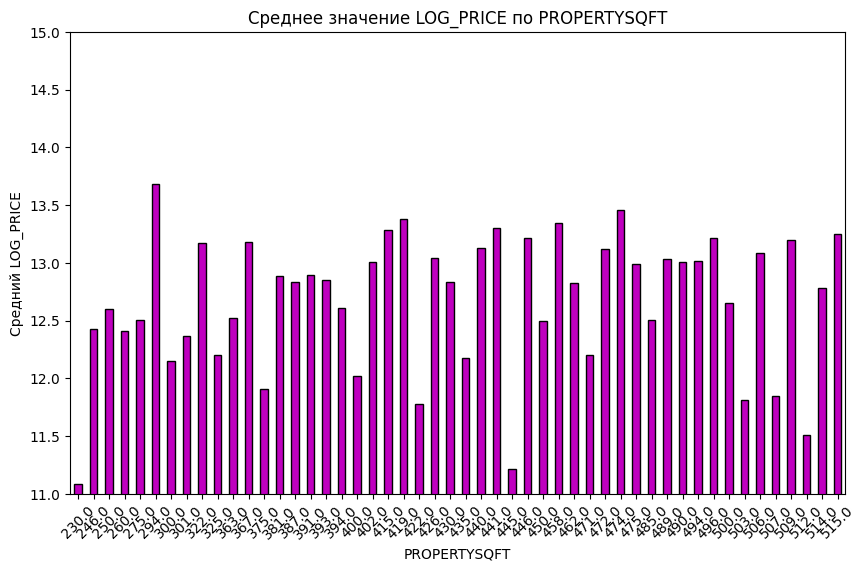

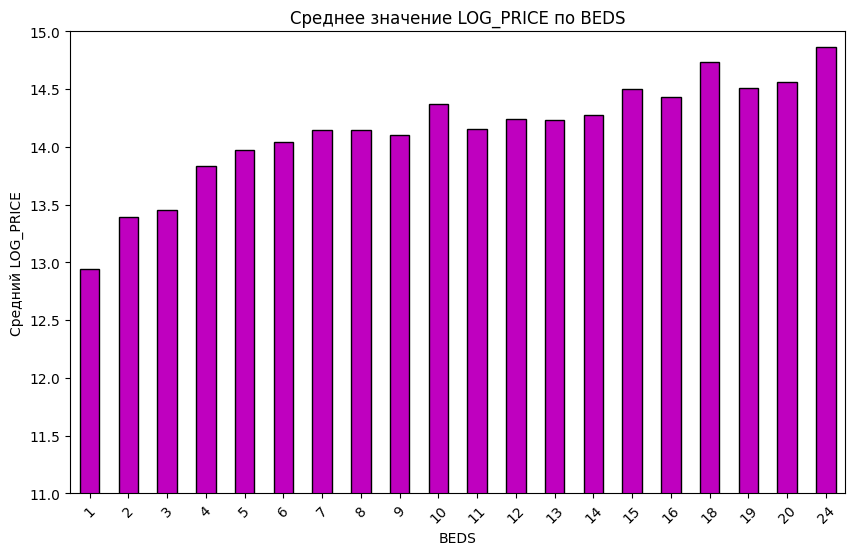

In [23]:
import matplotlib.pyplot as plt

# Устанавливаем ограничения для оси y
y_limit = (11, 15)

# SUBLOCALITY
plt.figure(figsize=(10, 6))
state_avg_price = df.groupby('SUBLOCALITY')['LOG_PRICE'].mean().head(100)
state_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение LOG_PRICE по SUBLOCALITY')
plt.xlabel('SUBLOCALITY')
plt.ylabel('Средний LOG_PRICE')
plt.ylim(y_limit)
plt.xticks(rotation=45)
plt.show()

# LOCALITY
plt.figure(figsize=(10, 6))
locality_avg_price = df.groupby('LOCALITY')['LOG_PRICE'].mean()
locality_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение LOG_PRICE по LOCALITY')
plt.xlabel('LOCALITY')
plt.ylabel('Средний LOG_PRICE')
plt.ylim(y_limit)
plt.xticks(rotation=45)
plt.show()

# PROPERTYSQFT
plt.figure(figsize=(10, 6))
propert_sqft_avg_price = df.groupby('PROPERTYSQFT')['LOG_PRICE'].mean().head(50)
propert_sqft_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение LOG_PRICE по PROPERTYSQFT')
plt.xlabel('PROPERTYSQFT')
plt.ylabel('Средний LOG_PRICE')
plt.ylim(y_limit)
plt.xticks(rotation=45)
plt.show()

# BEDS
plt.figure(figsize=(10, 6))
beds_avg_price = df.groupby('BEDS')['LOG_PRICE'].mean().head(100)
beds_avg_price.plot(kind='bar', color='m', edgecolor='black')
plt.title('Среднее значение LOG_PRICE по BEDS')
plt.xlabel('BEDS')
plt.ylabel('Средний LOG_PRICE')
plt.ylim(y_limit)
plt.xticks(rotation=45)
plt.show()


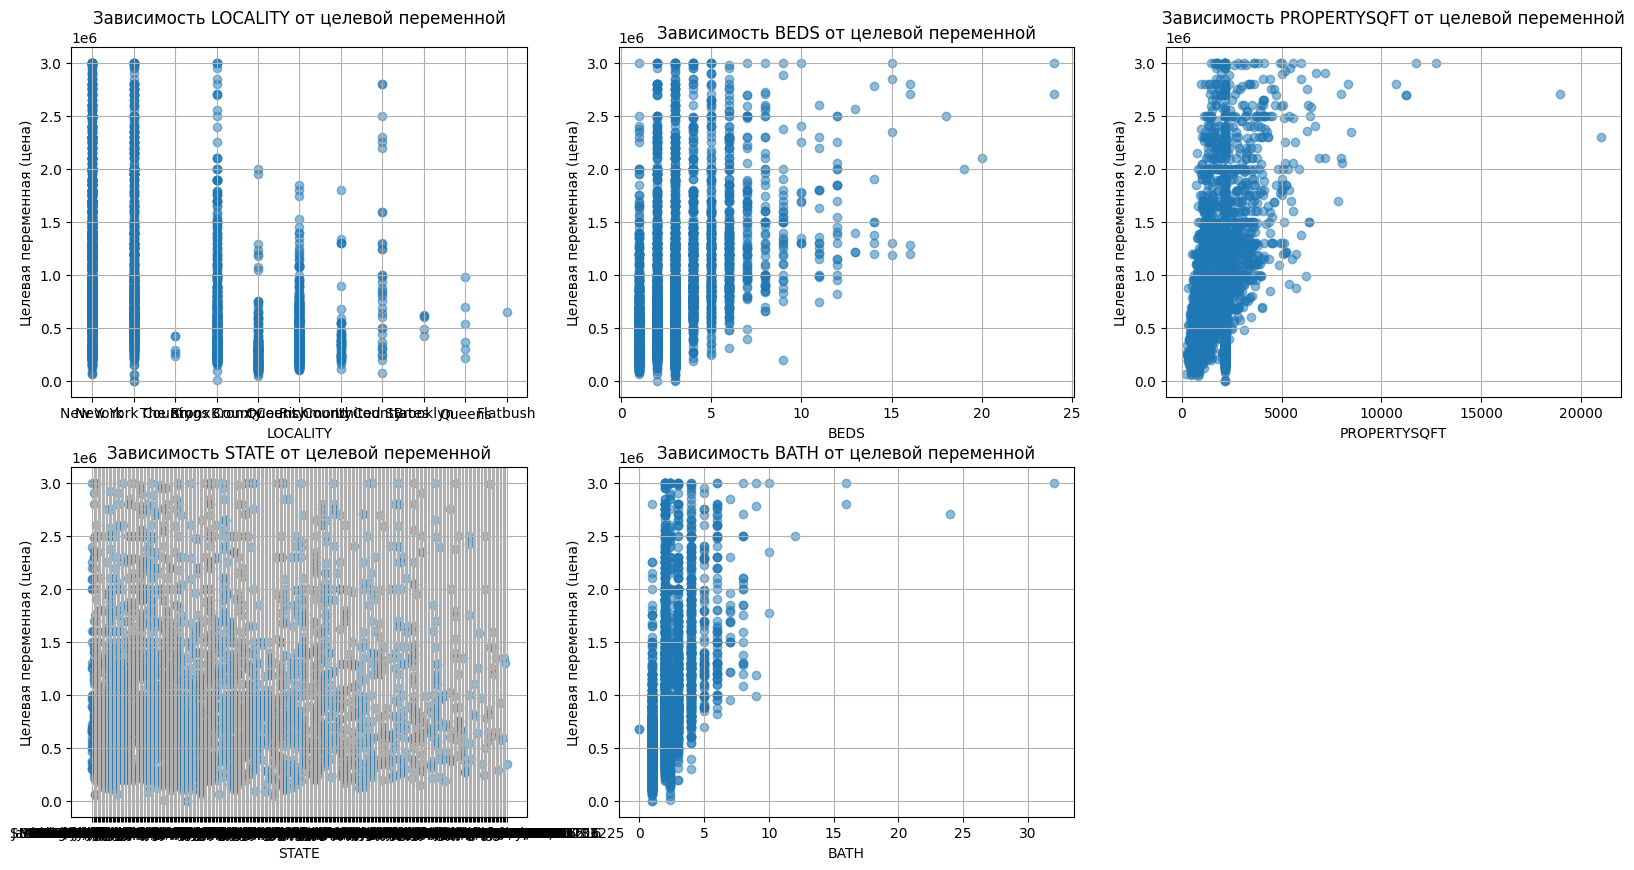

In [19]:
import matplotlib.pyplot as plt


features = ['LOCALITY', 'BEDS', 'PROPERTYSQFT', 'STATE', 'BATH']


plt.figure(figsize=(20, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(df[feature], df['PRICE'], alpha=0.5)
    plt.title(f'Зависимость {feature} от целевой переменной')
    plt.xlabel(feature)
    plt.ylabel('Целевая переменная (цена)')
    plt.grid(True)


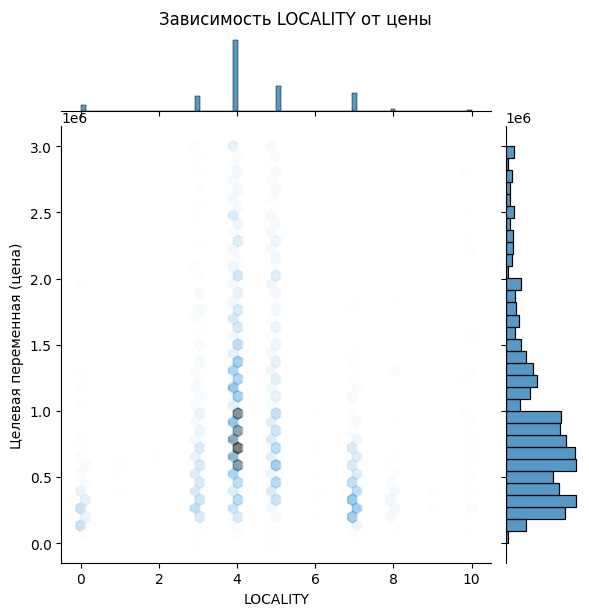

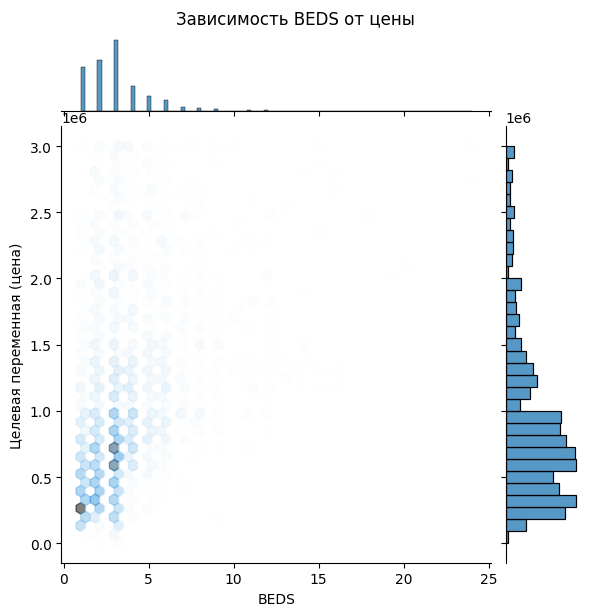

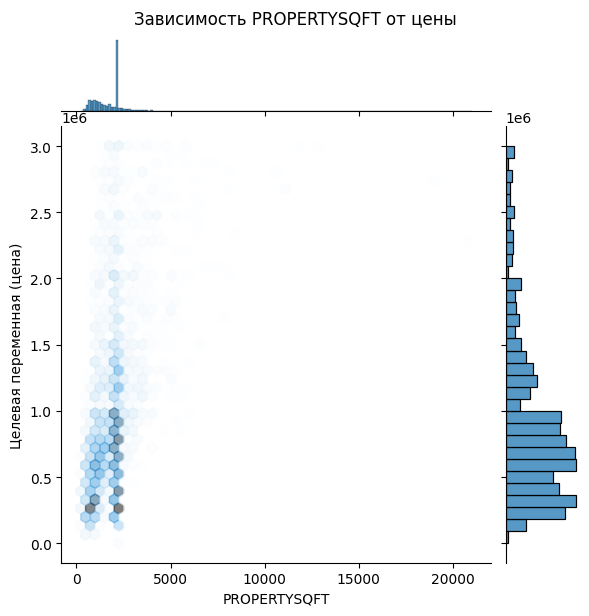

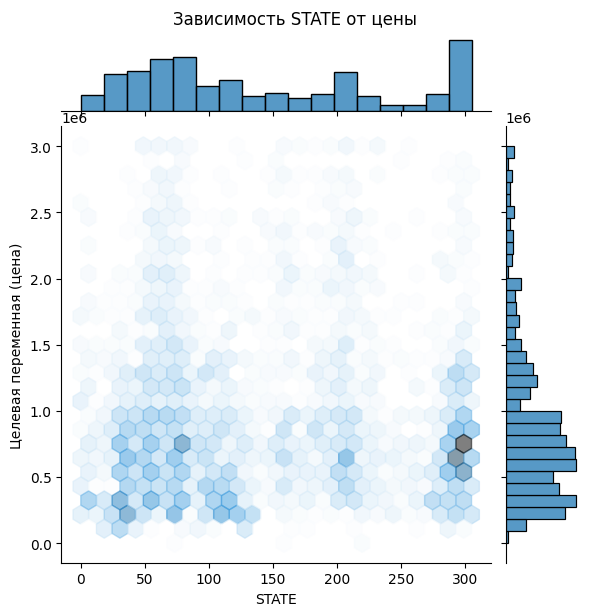

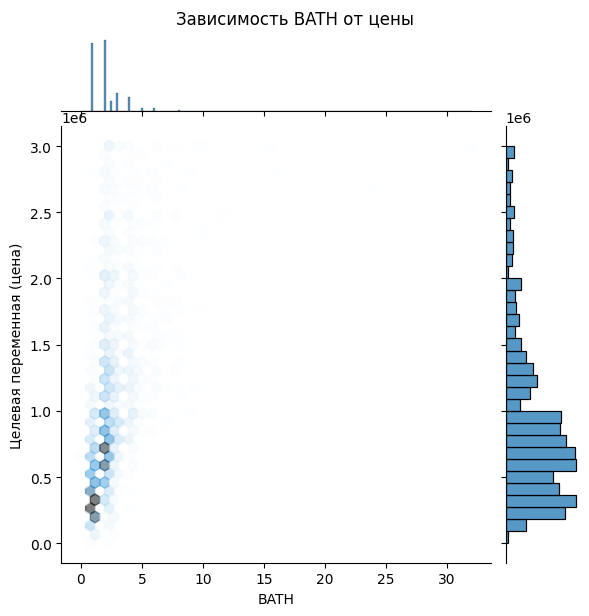

In [25]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['LOCALITY', 'STATE']:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

features = {
    'LOCALITY_encoded': 'LOCALITY',
    'BEDS': 'BEDS',
    'PROPERTYSQFT': 'PROPERTYSQFT',
    'STATE_encoded': 'STATE',
    'BATH': 'BATH'
}

for feature, original_name in features.items():
    sns.jointplot(data=df, x=feature, y='PRICE', kind='hex', alpha=0.5)
    plt.xlabel(original_name)
    plt.ylabel('Целевая переменная (цена)')
    plt.suptitle(f'Зависимость {original_name} от цены', y=1.02)
    plt.show()
